# Natural Language Processing and Swedish Mutual Funds

#### We will be using NLP on a collection of short descriptions of 1320 mutual funds. The primary NLP packages we will playing with is NLTK. The fund descriptions are in swedish, and NLTK does have some support for the swedish language.

#### First, we import some packages we'll be using and open the fund dictionary (i.e. hash table), which is currently stored in json format.

In [175]:
import nltk
from nltk.text import Text
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem.snowball import SwedishStemmer
from wordcloud import WordCloud, ImageColorGenerator
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.preprocessing import Normalizer, normalize
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import random
import pandas as pd
import numpy as np
import scipy as sp
from sklearn.pipeline import Pipeline
from sklearn.metrics import pairwise_distances
from PIL import Image
import json
from collections import defaultdict
import warnings
warnings.filterwarnings("ignore")

with open('dict_of_funds.json', 'r') as g:
     dict_of_funds = json.load(g)

In [80]:
len(dict_of_funds)

1319

#### There are 1320 funds and below is an example of the information available for a given fund. We will primarily be interested in a short 1-4 sentence summary ofthe fund, whichis stored under the key 'info'.

In [81]:
dict_of_funds['Handelsbanken Tillväxtmarknad Tema']

{'10_yr': 60.39,
 '1_yr': 20.54,
 '3_yr': 28.82,
 '5_yr': 70.81,
 'ISIN': 'SE0000429748',
 'bank': 'Handelsbanken',
 'category': 'Tillväxtmarknader',
 'fund_type': 'Aktiefond',
 'holdings': {'AIA Group Ltd': 2.0,
  'Alibaba Group Holding Ltd ADR': 6.8,
  'Kroton Educacional SA': 2.6,
  'NetEase Inc ADR': 2.4,
  'PT Bank Tabungan Negara (Persero) Tbk': 1.6,
  'Samsung Electronics Co Ltd': 4.2,
  'Sberbank of Russia PJSC': 2.6,
  'Taiwan Semiconductor Manufacturing Co Ltd': 5.6,
  'Tencent Holdings Ltd': 8.7,
  'Övrigt': 63.5},
 'industries': {'Fastigheter': 1.3,
  'Finans': 25.1,
  'Industri': 6.7,
  'Kommunikation': 2.8,
  'Konsument, cyklisk': 13.6,
  'Konsument, stabil': 11.0,
  'Råvaror': 1.2,
  'Sjukvård': 3.6,
  'Teknik': 34.7},
 'info': 'Fonden är en aktivt förvaltad värdepappersfond som placerar främst i börsnoterade aktier utgivna av företag i Asien, Latinamerika, Östeuropa och Afrika. Målet är att över tiden överträffa den genomsnittliga avkastningen på de aktuella aktiemarkna

#### Next we convert the dictionary to a pandas dataframe, which can be easily manipulated with respect to the operations we will be doing.

In [82]:
fund_df=pd.DataFrame.from_dict(dict_of_funds,orient='index')
fund_df.head()

,category,morningstar,bank,man_fee,sharpe_ratio,fund_type,3_yr,holdings,std_dev,normanbelopp,...,start_date,industries,info,ISIN,5_yr,1_yr,min_amt,sub_categories,regions,10_yr
Aktuellt från våra partners: Hur investerar man i Artificial Intelligence (AI) som är på frammarsch? Se intervjun i Avanza Play,Ny Teknologi,NaN,Allianz,1.75,NaN,Branschfond,NaN,"{'Övrigt': 64.0, 'Micron Technology Inc': 4.4,...",NaN,17620,...,2017-05-02,"{'Finans': 3.6, 'Industri': 3.0, 'Konsument, c...",Typ,LU1548497699,NaN,NaN,100,"Branschfond, ny teknik","{'Västeuropa exkl Sverige': 5.3, 'Nordamerika'...",NaN
10TEN Kvanthedge,Hedgefonder,NaN,10TEN,0.80,NaN,Hedgefond,NaN,{},NaN,7017,...,2016-08-02,{},Fonden är en aktivt förvaltad hedgefond som fö...,SE0008586945,NaN,2.99,25000,"Hedgefond, lång/kort, Europa",{},NaN
AGCM Asia Growth RC SEK,Asien,NaN,AGCM Asia Growth,1.85,NaN,Aktiefond,NaN,"{'China Overseas Land & Investment Ltd': 4.4, ...",NaN,18164,...,2014-10-03,"{'Konsument, cyklisk': 22.1, 'Konsument, stabi...",AGCM Asia Growth Fund är en aktivt förvaltad a...,LU1091660909,NaN,11.19,100,Asien ex Japan,{'Asien exkl Japan': 100.0},NaN
AMF Aktiefond Asien Stilla havet,Asien,3.0,AMF,0.40,0.74,Aktiefond,29.13,"{'Övrigt': 77.8, 'Taiwan Semiconductor Manufac...",12.81,3908,...,2008-09-25,"{'Övrigt': 4.7, 'Konsument, cyklisk': 8.1, 'Ko...",Fonden är en aktiefond med en bred inriktning ...,SE0002572313,67.32,11.52,50,Asien,"{'Australien och Nya Zeeland': 16.2, 'Västeuro...",NaN
AMF Aktiefond Europa,Europa,4.0,AMF,0.40,0.65,Aktiefond,26.54,"{'Övrigt': 69.1, 'Total SA': 4.5, 'GlaxoSmithK...",13.70,3821,...,1999-04-30,"{'Övrigt': 3.8, 'Konsument, cyklisk': 12.0, 'K...",Fonden är en aktiefond som placerar i marknads...,SE0000739153,89.54,16.98,50,"Europa, värdebolag","{'Östeuropa': 0.3, 'Västeuropa exkl Sverige': ...",43.63


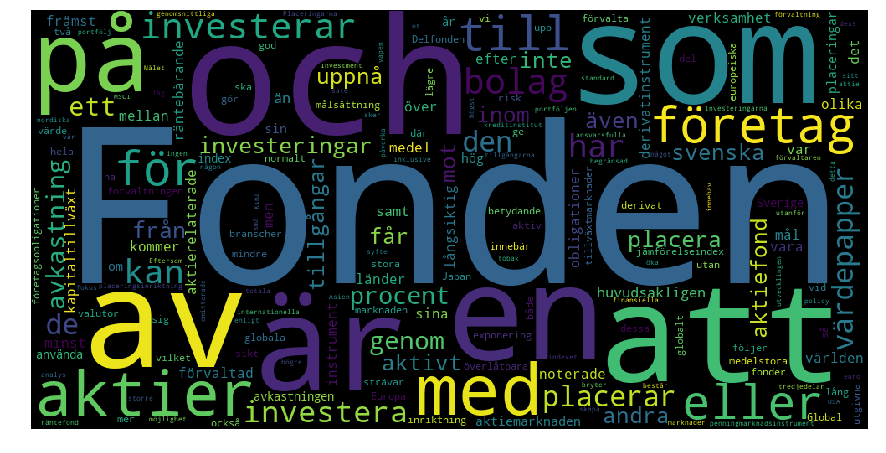

In [5]:
wordcloud = WordCloud(collocations=False,width = 1000, height = 500).generate(' '.join(fund_df['info']))
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

#### Most of the preprocessing we will be doing can be condensed into the function written below. We first split apart (i.e. tokenize) the 'info' string into a list of words, symbols, and punctuations. Then we remove allof the swedish stopwords. In english stopwords are words such as 'is', 'a', 'the', which are commonplace, but have little predictive value. 

#### After that we remove any tokens of length 1, which includes punctuation marks. The last step is to onlykeep the 'stem' of a word. For instance the stem of 'called' and 'cars' is 'call' and 'car'.

In [6]:
def fund_cleaner(df):
    for fund in list(df.index):
        info=df.loc[fund,'info']
        info=nltk.word_tokenize(info,'swedish')
        info=[word for word in info if word not in stopwords.words('swedish')]
        info=[word for word in info if len(word)>1]
        info=[SwedishStemmer().stem(word) for word in info]
        info=' '.join(info)
        df.loc[fund,'info']=info
    return df

#### Let's look at an example of the fund info before and after cleaning things up. Notice the length is reduced by around 1/3.

In [7]:
fund_df.loc['Amundi Fds SBI FM Eqty India Select AU-C','info']

'Delfondens mål är att söka långsiktig kapitaltillväxt genom att investera minst två 67 % av sina tillgångar i aktier i indiska företag. Delfonden kan investera i finansiella derivatinstrument för säkring och för effektiv förvaltning av portföljer. BSE 100 indexet utgör Delfondens referensindikator. Delfonden syftar inte till att replikera referensindikatorn och kan därför väsentligt avvika från den.'

In [83]:
_=fund_cleaner(fund_df)
fund_df.loc['Amundi Fds SBI FM Eqty India Select AU-C','info']

'delfond mål sök långsikt kapitaltillväxt genom invester minst två 67 tillgång akti indisk företag delfond invester finansiell derivatinstrument säkring effektiv förvaltning portfölj bse 100 indexet utgör delfond referensindikat delfond syft repliker referensindikatorn därför väsent avvik'

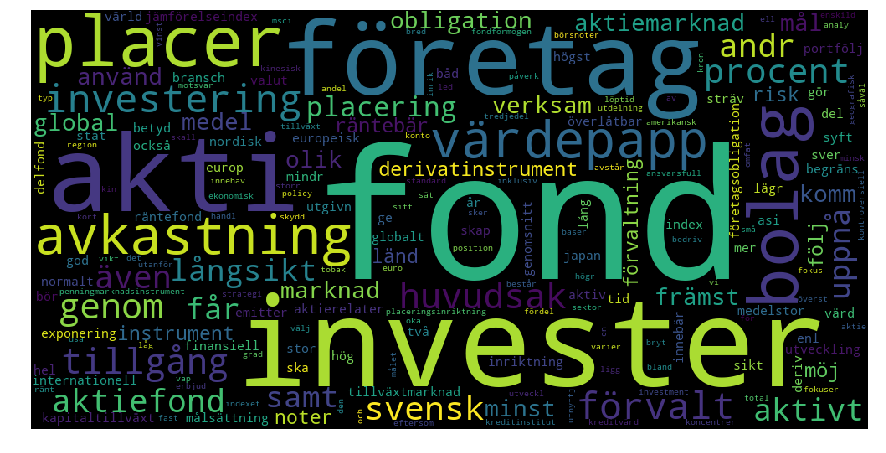

In [9]:
wordcloud = WordCloud(collocations=False,width = 1000, height = 500).generate(' '.join(fund_df['info']))
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

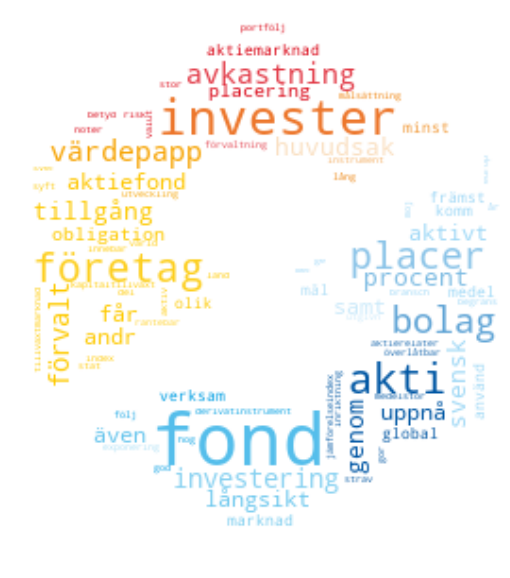

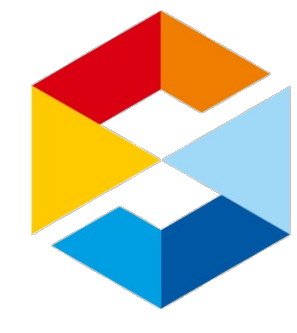

In [10]:
sbic_mask = np.array(Image.open( "SBIC.png"))

wordcloud = WordCloud(collocations=False,width = 1000, height = 500,mask=sbic_mask,background_color="white")
wordcloud.generate(' '.join(fund_df['info']))
image_colors = ImageColorGenerator(sbic_mask)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")
plt.figure()
plt.imshow(sbic_mask, cmap=plt.cm.gray, interpolation="bilinear")
plt.axis("off")
plt.show()

#### First we apply an unsupervised methods to group funds based on 'info'. The process consists of the following steps:

#### 1) For each fund 'info' and for each unique word in 'info',  count the number of times the word occurs in the fund 'info' and divide this by the number of times the word occurs in all funds 'info'. This is known as Term Frequency Inverse Document Frequency (i.e. tfidf ), and the output is a large sparse matrix where each row corresponds to a particular fund's 'info'.

#### 2) Apply a truncated Singular Value Decomposition (i.e. svd ), which attempts to compress the less usefule information in the matrix. 

#### This process more commonly goes by thename Latent Semantic Analysis or LDA.

In [11]:
svd_model=TruncatedSVD(n_components=500,algorithm='arpack')

transformer = TfidfVectorizer()

svd_transformer = Pipeline([('tfidf', transformer), 
                            ('svd', svd_model)])

svd_matrix = svd_transformer.fit_transform(fund_df['info'].values)

#### Now that each fund has been transformed into a vector in a high-dimensional space, let's see what fund's are similar to a given fund by comparing the fund vectors. In particular, we use the cosine distance to give the angle between vectors. If the two vectors are the same, then the angle will be zero.

In [12]:
def k_similar_funds(fund,k,fund_df):
    query_fund = svd_transformer.transform([fund_df.loc[fund,'info']])
    distance_matrix = pairwise_distances(query_fund, 
                                     svd_matrix, 
                                     metric='cosine', 
                                     n_jobs=-1)
    indices=distance_matrix[0,:].argsort()[:k+1]
    for i in indices:
        print('Fund Name: '+fund_df.index[i])
        print('Fund Category: '+fund_df['category'].iloc[i])
        print('')

In [13]:
k_similar_funds('AMF Aktiefond Sverige',5,fund_df)

Fund Name: AMF Aktiefond Sverige
Fund Category: Sverige

Fund Name: Monyx Svenska Aktier
Fund Category: Sverige

Fund Name: AMF Aktiefond Europa
Fund Category: Europa

Fund Name: SEB Världenfond
Fund Category: Blandfonder

Fund Name: SEB Nordic Focus C SEK
Fund Category: Norden

Fund Name: SEB Trygg Placeringsfond
Fund Category: Blandfonder



##### Above we see the five 'closest' funds to the fund AMF Aktiefond Sverige. Comparing this to the fund categories seems to show only a minor correlation between the fund's 'info' and the fund's category.

#### However, if we look at the geographical distribution of a couple of those funds we see a heavy investment presence in Sweden (i.e. Sverige), which is somewhat encouraging.

In [14]:
print('Geographical Distribution of SEB Nordic Focus C SEK investments: {}'.format(fund_df.loc['SEB Nordic Focus C SEK','regions']))
print('-----------------------------------------------------------------------------------------------------------')
print('Geographical Distribution of SEB Trygg Placeringsfond investments: {}'.format(fund_df.loc['SEB Trygg Placeringsfond','regions']))

Geographical Distribution of SEB Nordic Focus C SEK investments: {'Nordamerika': 3.7, 'Västeuropa exkl Sverige': 52.4, 'Sverige': 43.9}
-----------------------------------------------------------------------------------------------------------
Geographical Distribution of SEB Trygg Placeringsfond investments: {'Nordamerika': 33.2, 'Latinamerika': 0.0, 'Asien exkl Japan': 5.1, 'Östeuropa': 3.7, 'Australien och Nya Zeeland': 0.7, 'Afrika och Mellanöstern': 0.2, 'Västeuropa exkl Sverige': 13.4, 'Sverige': 36.9, 'Japan': 6.9}


#### Below we see that there are 37 distinct fund categories, and some of the categories have as few as 2 funds. This is a mutli-class dataset with significant class imbalance.

In [15]:
print('# of fund categories: {}'.format(len(fund_df.groupby('category').count().index)))
fund_df.loc[:,['info','category']].groupby('category').count()

# of fund categories: 37


,info
category,
-,21
Afrika och Mellanöstern,14
Asien,135
BRIC,3
Bioteknologi,6
Blandfonder,95
Brasilien,5
EURO,36
Energi,5


#### We now move on to supervised learning via classification, and we begin by splitting the dataset of funds into a traing set and a test set. We randomly split a quarter of the set into the test set, and do so by maintaing the ratio of classes/categories.

#### Given the combination of the imbalanced classes and the small populations of many of the fund classes, our expectations should not be too high. Additionally, there is a wide range in the length of each fund's text, which will bias our estimator towards longer texts.

In [16]:
def data_split(df):
    test_funds=[]
    class_counts=df.loc[:,['info','category']].groupby('category').count()
    test_counts=class_counts['info'].apply(lambda x: int(0.25*x))
    for index, count in test_counts.iteritems():
        indices=random.sample(range(0,class_counts.loc[index][0]),count)
        test_funds+=list(df.loc[fund_df['category']==index].index[indices])
    return test_funds

In [17]:
test_index=data_split(fund_df)
test_set=fund_df.loc[test_index,:]
train_set=fund_df.loc[~fund_df.index.isin(test_index)]

In [18]:
X_test=test_set['info'].values
y_test=test_set['category'].values
X_train=train_set['info'].values
y_train=train_set['category'].values

  Actual number of tfidf features: 3491
Some random words in the vocabulary:
  reflekter
  prospek
  lån
  mänsk
  antalet
  dess
  saml
  bra
  granit
  bhutan
(800, 3491)
(800,)


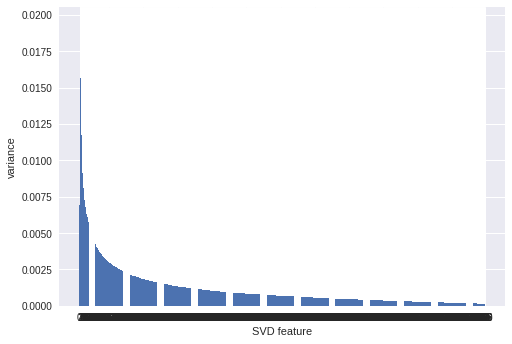

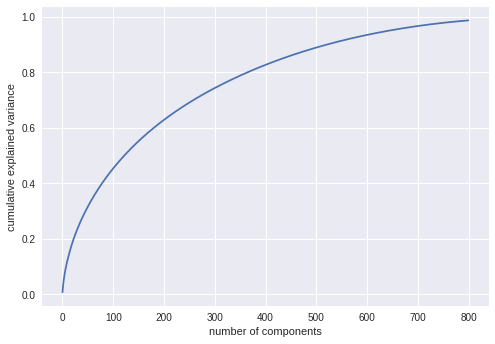

In [19]:
svd=TruncatedSVD(n_components=800)
vectorizer=TfidfVectorizer()

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print("  Actual number of tfidf features: %d" % X_train_tfidf.get_shape()[1])

feat_names = vectorizer.get_feature_names()

print("Some random words in the vocabulary:")
for i in range(0, 10):
    featNum = random.randint(0, len(feat_names))
    print("  %s" % feat_names[featNum])
    
X_train_lsa = svd.fit_transform(X_train_tfidf)
X_test_lsa = svd.transform(X_test_tfidf)

print(svd.components_.shape)
print(svd.explained_variance_.shape)
features = range(svd.components_.shape[0])
plt.bar(features, svd.explained_variance_)
plt.xlabel('SVD feature')
plt.ylabel('variance')
plt.xticks(features)
plt.show()

plt.plot(np.cumsum(svd.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.show()

#### We need a couple of functions for running a Naive Bayes classifier based on a multinomial distribution and a function to show how each category fared.

#### A Naive Bayes classifier makes a naive assumption that the features (i.e. word frequencies) are statistically independent. For some words this may be true, but for many this is not true at all (i.e. 'mutual' and 'fund'). Later we can use n-grams (multiple words) as features to help this situation.

In [20]:
def score_counts(y_test,y_predic):
    correct_counts=defaultdict(int)
    counts=defaultdict(int)
    i=0
    for fund_class in y_test:
        counts[fund_class]+=1
        if fund_class==y_predic[i]:
            correct_counts[fund_class]+=1
        i+=1
    
    if printing==True:
        print("Accuracy: {}".format(sum(correct_counts.values())/sum(counts.values())))
        for key, value in counts.items():
            print(key+": {}".format(correct_counts[key])+'/{}'.format(value))
        
    return (correct_counts,counts)

In [21]:
def NB_classify_and_score(X_train,y_train,X_test,y_test):
    steps = [('tfid', TfidfVectorizer()),
             ('NB', MultinomialNB())]

    pipeline = Pipeline(steps)

    pipeline.fit(X_train,y_train)
    
    y_predic = pipeline.predict(X_test)
    
    score_counts(y_test,y_predic)
    
    return pipeline.score(X_test,y_test)

In [22]:
def MNB_classify_and_score(X_train,y_train,X_test,y_test):
    steps = [('count', CountVectorizer()),
             ('NB', MultinomialNB())]

    pipeline = Pipeline(steps)

    pipeline.fit(X_train,y_train)
    
    y_predic = pipeline.predict(X_test)
    
    score_counts(y_test,y_predic)
    
    return pipeline.score(X_test,y_test)

In [23]:
def NB_CV_classify_and_score(X_train,y_train,X_test,y_test):
    steps = [('tfid', TfidfVectorizer()),
             ('NB', MultinomialNB())]
    
    param_grid={'tfid__ngram_range':[(1,1),(1,2),(2,2),(1,3),(2,3)],
                'NB__alpha':[0.2,0.5,1]}
    
    pipeline = Pipeline(steps)

    nb_cv=GridSearchCV(pipeline,param_grid,cv=5)

    nb_cv.fit(X_train,y_train)
    
    y_predic = nb_cv.predict(X_test)
    
    print("Tuned Parameter: {}".format(nb_cv.best_params_))
    
    score_counts(y_test,y_predic)
    
    return nb_cv.score(X_test,y_test)

In [24]:
def KNN_classify_and_score(X_train,y_train,X_test,y_test):
    steps = [('tfid', TfidfVectorizer()),
             ('knn', KNeighborsClassifier(n_jobs=-1))]
    
    neighbors=np.arange(2,9)
    param_grid={'tfid__ngram_range':[(1,1),(1,2),(2,2)],
                'knn__n_neighbors':neighbors,
                'knn__metric':['minkowski','cosine']}
    
    pipeline = Pipeline(steps)

    knn_cv=GridSearchCV(pipeline,param_grid,cv=5)

    knn_cv.fit(X_train,y_train)
    
    y_predic = knn_cv.predict(X_test)
    
    print("Tuned Parameter: {}".format(knn_cv.best_params_))
    
    score_counts(y_test,y_predic)
    
    return knn_cv.score(X_test,y_test)

In [25]:
def SVC_classify_and_score(X_train,y_train,X_test,y_test):
    steps = [('tfid', TfidfVectorizer()),
             ('svc', SGDClassifier(n_jobs=-1, loss='hinge'))]
    
    neighbors=np.arange(2,9)
    param_grid={'tfid__ngram_range':[(1,1),(1,2),(2,2)],
                'svc__penalty':['l1','l2','elasticnet']}
    
    pipeline = Pipeline(steps)

    svc_cv=GridSearchCV(pipeline,param_grid,cv=5)

    svc_cv.fit(X_train,y_train)
    
    y_predic = svc_cv.predict(X_test)
    
    print("Tuned Parameter: {}".format(svc_cv.best_params_))
    
    score_counts(y_test,y_predic)
    
    return svc_cv.score(X_test,y_test)

In [26]:
def LR_classify_and_score(X_train,y_train,X_test,y_test):
    steps = [('tfid', TfidfVectorizer()),
             ('lr', SGDClassifier(n_jobs=-1,loss='log'))]
    
    neighbors=np.arange(2,9)
    param_grid={'tfid__ngram_range':[(1,1),(1,2),(2,2)],
                'lr__penalty':['l1','l2','elasticnet']}
    
    pipeline = Pipeline(steps)

    lr_cv=GridSearchCV(pipeline,param_grid,cv=5)

    lr_cv.fit(X_train,y_train)
    
    y_predic = lr_cv.predict(X_test)
    
    print("Tuned Parameter: {}".format(lr_cv.best_params_))
    
    score_counts(y_test,y_predic)
    
    return lr_cv.score(X_test,y_test)

#### Below we can see a comparison of Naive Bayes, K-Nearest Neighbors, Logistic Regression, and Linear SVM some with and without the TF-IDF transformation. Linear SVM and Logistic Regression implemented with stochastic gradient descent appears to be the winners. Naive Bayes appears to do better without the TF-IDF transormation.

#### Unsurprisingly, the under represented fund categories performed the worst as far as accuracy.

In [27]:
printing=False

scores={'MNB_tfifd':NB_classify_and_score(X_train,y_train,X_test,y_test),'MNB':MNB_classify_and_score(X_train,y_train,X_test,y_test),
        'MNB_tfifd_reg':NB_CV_classify_and_score(X_train,y_train,X_test,y_test), 'KNN_tfifd':KNN_classify_and_score(X_train,y_train,X_test,y_test),
        'SVC_tfifd_reg':SVC_classify_and_score(X_train,y_train,X_test,y_test),'LogReg_tfidf_reg':LR_classify_and_score(X_train,y_train,X_test,y_test)}

Tuned Parameter: {'NB__alpha': 0.2, 'tfid__ngram_range': (1, 1)}
Tuned Parameter: {'tfid__ngram_range': (1, 1), 'knn__n_neighbors': 8, 'knn__metric': 'minkowski'}
Tuned Parameter: {'svc__penalty': 'l1', 'tfid__ngram_range': (1, 2)}
Tuned Parameter: {'lr__penalty': 'l1', 'tfid__ngram_range': (1, 1)}


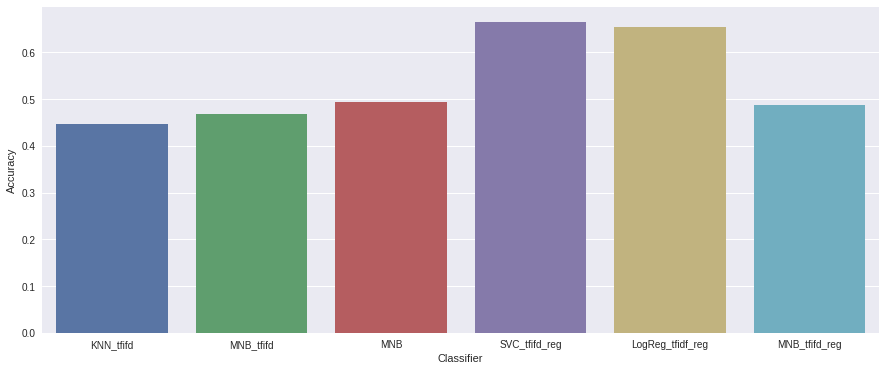

In [28]:
sns.set()
plt.figure(figsize=(15, 6))
sns.barplot(x=[name for name, _ in scores.items()], y=[score for _, score in scores.items()])
plt.xlabel('Classifier')
plt.ylabel('Accuracy')
plt.show()

printing=True

In [29]:
scores

{'KNN_tfifd': 0.44620253164556961,
 'LogReg_tfidf_reg': 0.65506329113924056,
 'MNB': 0.49367088607594939,
 'MNB_tfifd': 0.46835443037974683,
 'MNB_tfifd_reg': 0.48734177215189872,
 'SVC_tfifd_reg': 0.66455696202531644}

In [30]:
NB_classify_and_score(X_train,y_train,X_test,y_test)

Accuracy: 0.46835443037974683
Konvertibler: 0/1
Afrika och Mellanöstern: 0/3
Blandfonder: 15/23
Ryssland: 0/4
USD: 0/2
-: 0/5
Ädelmetaller: 0/1
SEK: 15/19
Europa: 17/28
Finans: 0/1
Brasilien: 0/1
Nordamerika: 1/15
Japan: 0/8
Fastigheter: 0/6
Övriga: 20/25
Latinamerika: 0/3
Asien: 28/33
Läkemedel: 0/3
Råvaror: 0/3
Tillväxtmarknader: 1/18
Bioteknologi: 0/1
Ny Teknologi: 0/5
Turkiet: 0/1
Infrastruktur: 0/1
Energi: 0/1
Miljö: 0/1
Östeuropa: 0/5
Global: 22/31
Hedgefonder: 9/21
Sverige: 20/26
Ny Energi: 0/1
EURO: 0/9
Konsument: 0/2
Norden: 0/9


0.46835443037974683

In [31]:
NB_CV_classify_and_score(X_train,y_train,X_test,y_test)

Tuned Parameter: {'NB__alpha': 0.2, 'tfid__ngram_range': (1, 1)}
Accuracy: 0.4873417721518987
Konvertibler: 0/1
Afrika och Mellanöstern: 0/3
Blandfonder: 15/23
Ryssland: 0/4
USD: 0/2
-: 0/5
Ädelmetaller: 0/1
SEK: 17/19
Europa: 17/28
Finans: 0/1
Brasilien: 0/1
Nordamerika: 2/15
Japan: 1/8
Fastigheter: 0/6
Övriga: 19/25
Latinamerika: 0/3
Asien: 27/33
Läkemedel: 0/3
Råvaror: 0/3
Tillväxtmarknader: 2/18
Bioteknologi: 0/1
Ny Teknologi: 0/5
Turkiet: 0/1
Infrastruktur: 0/1
Energi: 0/1
Miljö: 0/1
Östeuropa: 0/5
Global: 19/31
Hedgefonder: 15/21
Sverige: 19/26
Ny Energi: 0/1
EURO: 1/9
Konsument: 0/2
Norden: 0/9


0.48734177215189872

In [32]:
MNB_classify_and_score(X_train,y_train,X_test,y_test)

Accuracy: 0.4936708860759494
Konvertibler: 0/1
Afrika och Mellanöstern: 0/3
Blandfonder: 18/23
Ryssland: 0/4
USD: 0/2
-: 0/5
Ädelmetaller: 0/1
SEK: 17/19
Europa: 16/28
Finans: 0/1
Brasilien: 0/1
Nordamerika: 2/15
Japan: 0/8
Fastigheter: 0/6
Övriga: 18/25
Latinamerika: 0/3
Asien: 26/33
Läkemedel: 0/3
Råvaror: 0/3
Tillväxtmarknader: 3/18
Bioteknologi: 0/1
Ny Teknologi: 0/5
Turkiet: 0/1
Infrastruktur: 0/1
Energi: 0/1
Miljö: 0/1
Östeuropa: 0/5
Global: 18/31
Hedgefonder: 15/21
Sverige: 21/26
Ny Energi: 0/1
EURO: 2/9
Konsument: 0/2
Norden: 0/9


0.49367088607594939

In [33]:
KNN_classify_and_score(X_train,y_train,X_test,y_test)

Tuned Parameter: {'tfid__ngram_range': (1, 1), 'knn__n_neighbors': 8, 'knn__metric': 'minkowski'}
Accuracy: 0.4462025316455696
Konvertibler: 0/1
Afrika och Mellanöstern: 0/3
Blandfonder: 12/23
Ryssland: 0/4
USD: 0/2
-: 0/5
Ädelmetaller: 0/1
SEK: 16/19
Europa: 17/28
Finans: 0/1
Brasilien: 0/1
Nordamerika: 7/15
Japan: 4/8
Fastigheter: 1/6
Övriga: 13/25
Latinamerika: 1/3
Asien: 24/33
Läkemedel: 1/3
Råvaror: 1/3
Tillväxtmarknader: 3/18
Bioteknologi: 0/1
Ny Teknologi: 2/5
Turkiet: 0/1
Infrastruktur: 0/1
Energi: 0/1
Miljö: 0/1
Östeuropa: 1/5
Global: 12/31
Hedgefonder: 9/21
Sverige: 12/26
Ny Energi: 0/1
EURO: 2/9
Konsument: 0/2
Norden: 3/9


0.44620253164556961

In [34]:
SVC_classify_and_score(X_train,y_train,X_test,y_test)

Tuned Parameter: {'svc__penalty': 'l1', 'tfid__ngram_range': (1, 2)}
Accuracy: 0.6708860759493671
Konvertibler: 0/1
Afrika och Mellanöstern: 1/3
Blandfonder: 17/23
Ryssland: 3/4
USD: 0/2
-: 0/5
Ädelmetaller: 0/1
SEK: 16/19
Europa: 20/28
Finans: 0/1
Brasilien: 1/1
Nordamerika: 13/15
Japan: 6/8
Fastigheter: 2/6
Övriga: 18/25
Latinamerika: 1/3
Asien: 30/33
Läkemedel: 1/3
Råvaror: 1/3
Tillväxtmarknader: 12/18
Bioteknologi: 0/1
Ny Teknologi: 1/5
Turkiet: 0/1
Infrastruktur: 0/1
Energi: 0/1
Miljö: 0/1
Östeuropa: 3/5
Global: 18/31
Hedgefonder: 14/21
Sverige: 23/26
Ny Energi: 0/1
EURO: 5/9
Konsument: 0/2
Norden: 6/9


0.67088607594936711

In [35]:
LR_classify_and_score(X_train,y_train,X_test,y_test)

Tuned Parameter: {'lr__penalty': 'l1', 'tfid__ngram_range': (1, 1)}
Accuracy: 0.6613924050632911
Konvertibler: 0/1
Afrika och Mellanöstern: 0/3
Blandfonder: 18/23
Ryssland: 2/4
USD: 0/2
-: 0/5
Ädelmetaller: 0/1
SEK: 16/19
Europa: 24/28
Finans: 0/1
Brasilien: 0/1
Nordamerika: 13/15
Japan: 6/8
Fastigheter: 1/6
Övriga: 16/25
Latinamerika: 1/3
Asien: 29/33
Läkemedel: 1/3
Råvaror: 0/3
Tillväxtmarknader: 12/18
Bioteknologi: 0/1
Ny Teknologi: 1/5
Turkiet: 0/1
Infrastruktur: 0/1
Energi: 0/1
Miljö: 0/1
Östeuropa: 1/5
Global: 21/31
Hedgefonder: 15/21
Sverige: 22/26
Ny Energi: 0/1
EURO: 5/9
Konsument: 0/2
Norden: 5/9


0.66139240506329111

#### Let's run it again, but this time using only the top 5 most populated fund categories.

In [36]:
top_classes=list(fund_df.loc[:,['info','category']].groupby('category').count().sort_values('info',ascending=False).head(5).index)
print(top_classes)

['Asien', 'Global', 'Europa', 'Sverige', 'Övriga']


In [37]:
X_test_sub=test_set.loc[test_set['category'].isin(top_classes)]['info'].values
y_test_sub=test_set.loc[test_set['category'].isin(top_classes)]['category'].values
X_train_sub=train_set.loc[train_set['category'].isin(top_classes)]['info'].values
y_train_sub=train_set.loc[train_set['category'].isin(top_classes)]['category'].values

#### Our accuracy has almost doubled to 81%, which is a nice improvement. We could either gather more dataon the under represented categories, or we could consider consolidating some of the fund categories to get better performance outof our classifier. Of course, we have only tried a fairly basic classifier, so there are many more methods we can consider. 

In [38]:
NB_classify_and_score(X_train_sub,y_train_sub,X_test_sub,y_test_sub)

Accuracy: 0.7272727272727273
Asien: 29/33
Europa: 13/28
Sverige: 21/26
Övriga: 22/25
Global: 19/31


0.72727272727272729

In [39]:
NB_CV_classify_and_score(X_train_sub,y_train_sub,X_test_sub,y_test_sub)

Tuned Parameter: {'NB__alpha': 1, 'tfid__ngram_range': (1, 1)}
Accuracy: 0.7272727272727273
Asien: 29/33
Europa: 13/28
Sverige: 21/26
Övriga: 22/25
Global: 19/31


0.72727272727272729

In [40]:
MNB_classify_and_score(X_train_sub,y_train_sub,X_test_sub,y_test_sub)

Accuracy: 0.7552447552447552
Asien: 26/33
Europa: 19/28
Sverige: 22/26
Övriga: 23/25
Global: 18/31


0.75524475524475521

In [41]:
KNN_classify_and_score(X_train_sub,y_train_sub,X_test_sub,y_test_sub)

Tuned Parameter: {'tfid__ngram_range': (1, 2), 'knn__n_neighbors': 8, 'knn__metric': 'minkowski'}
Accuracy: 0.6853146853146853
Asien: 25/33
Europa: 16/28
Sverige: 21/26
Övriga: 20/25
Global: 16/31


0.68531468531468531

In [42]:
SVC_classify_and_score(X_train_sub,y_train_sub,X_test_sub,y_test_sub)

Tuned Parameter: {'svc__penalty': 'l1', 'tfid__ngram_range': (1, 1)}
Accuracy: 0.8391608391608392
Asien: 30/33
Europa: 22/28
Sverige: 23/26
Övriga: 21/25
Global: 24/31


0.83916083916083917

In [43]:
LR_classify_and_score(X_train_sub,y_train_sub,X_test_sub,y_test_sub)

Tuned Parameter: {'lr__penalty': 'l1', 'tfid__ngram_range': (1, 1)}
Accuracy: 0.8321678321678322
Asien: 29/33
Europa: 23/28
Sverige: 22/26
Övriga: 22/25
Global: 23/31


0.83216783216783219

#### Before we move on to other methods let's look at 'fund_type' as opposed to fund 'category'. There are only 7 fund types as opposed to 37 fund categories. However, class imbalance is still an issue, since the 'Aktiefond' type is heavily represented in the dataset.

In [44]:
print('# of fund types: {}'.format(len(fund_df.groupby('fund_type').count().index)))
fund_df.loc[:,['info','fund_type']].groupby('fund_type').count()

# of fund types: 7


,info
fund_type,
-,22
Aktiefond,762
Blandfond,95
Branschfond,126
Hedgefond,87
Räntefond,224
Övrigt,4


In [45]:
def data_split(df,column):
    test_funds=[]
    class_counts=df.loc[:,['info',column]].groupby(column).count()
    test_counts=class_counts['info'].apply(lambda x: int(0.25*x))
    for index, count in test_counts.iteritems():
        indices=random.sample(range(0,class_counts.loc[index][0]),count)
        test_funds+=list(df.loc[fund_df[column]==index].index[indices])
    
    return test_funds

In [46]:
test_index=data_split(fund_df,'fund_type')
test_set=fund_df.loc[test_index,:]
train_set=fund_df.loc[~fund_df.index.isin(test_index)]

In [47]:
X_test=test_set['info'].values
y_test=test_set['fund_type'].values
X_train=train_set['info'].values
y_train=train_set['fund_type'].values

In [48]:
NB_classify_and_score(X_train,y_train,X_test,y_test)

Accuracy: 0.654434250764526
Branschfond: 0/31
Övrigt: 0/1
Aktiefond: 190/190
-: 0/5
Hedgefond: 0/21
Räntefond: 24/56
Blandfond: 0/23


0.65443425076452599

In [49]:
SVC_classify_and_score(X_train,y_train,X_test,y_test)

Tuned Parameter: {'svc__penalty': 'l1', 'tfid__ngram_range': (1, 2)}
Accuracy: 0.8562691131498471
Branschfond: 18/31
Övrigt: 1/1
Aktiefond: 184/190
-: 0/5
Hedgefond: 10/21
Räntefond: 52/56
Blandfond: 15/23


0.85626911314984711

#### Over 67% of the funds in the test set are correctly given the fund type by the Naive Bayes classifier. This isn't too bad, but we should be able to do better by bringing in other features and methods.

#### Let's consider the traditional Multinomial Naive Bayes model for text classification given by:

$$P(c\vert d) = \frac{P(c) \Pi_{w \in d} P(w \vert c)^{n_{w,d}}}{P(d)}, \qquad \text{and} \qquad P(w \vert c) = \frac{1+\sum_{d \in D_c} n_{w,d}}{k+\sum_{w'}\sum_{d \in D_c}n_{w',d}}$$

#### where $P(c)$ is calculated from the class, $c$, frequency in the dataset, $P(d)$ is chosen to make the first quantity a probability(i.e sum to 1), $d$ is a given document, $w$, $w'$ are words in the dataset or document, $n_{w,d}$ is the frequency of word, $w$, in document, $d$, and $D_c$ is the set of documents in class $c$ from the dataset.

#### The 1 and $k$ added in the numerator and denominator, respectively, of the second equation are known as the Laplace correction, and the idea is to have a small, but nonzero probability for a word appearing in a particular class even if it does not happen in the training set.

#### For imbalanced text classfication there are some adjustments that can be made to Tf-idf and Multinomial Naive Bayes that lead to better performance. The following functions perform the adjustments outlined in this paper:
https://people.csail.mit.edu/jrennie/papers/icml03-nb.pdf

#### Primarily, we are applying a log-transform to the word counts, so that they adhere less to a power-law distribution and more to a multinomial distribution. Then we normalize the resulting document vectors, so that larger documents are not weighted more than smaller documents. Next a modified form of Naive Bayes known as Weighted Complement Naive Bayes is applied, which calculates the probability for each class by looking at the complement probability given by grouping the remaining class into one class, and then normalize this value.

In [27]:
def word_class_weights(df):
    info_dict={}
    for fund in df.index:
        fund_count=Counter(df.loc[fund,'info'].split(' '))
        info_dict[fund]=fund_count
    categories=df['category'].unique()
    word_df=pd.DataFrame.from_dict(info_dict,orient='index')
    word_df.fillna(0,inplace=True)
    word_df=word_df.apply(lambda x: np.log(x+1))
    n=len(word_df.index)
    m=len(word_df.columns)
    column_sums=word_df.apply(lambda x: x!=0).sum(0)
    for column in word_df:
        word_df[column]=word_df[column].apply(lambda x: x*np.log(n/column_sums[column]))
    row_norms=((word_df**2).sum(1))**0.5
    word_df=word_df.div(row_norms,axis=0)
    word_df=word_df.join(df['category'])
    weight_dict={}
    for category in categories:
        weight_dict[category]=((word_df.groupby('category').sum(axis=0).drop(category).sum(axis=0)+1)/(word_df.groupby('category').sum(axis=0).drop(category).sum(axis=0).sum()+m)).apply(np.log)
        weight_dict[category]=weight_dict[category]/(weight_dict[category].sum())
    word_df=pd.DataFrame.from_dict(weight_dict,orient='index')
    return word_df

In [28]:
def word_counts(df):
    info_dict={}
    for fund in df.index:
        fund_count=Counter(df.loc[fund,'info'].split(' '))
        info_dict[fund]=fund_count
    word_df=pd.DataFrame.from_dict(info_dict,orient='index')
    word_df.fillna(0,inplace=True)
    word_df=word_df.join(df['category'])
    return word_df

#### This modified implementation of is especially constructed for imbalanced text processing, and it is known as the Transformed  Weighted Complement Naive Bayes (TWCNB).

In [29]:
def TWCNB(train_df,test_df):
    weights=word_class_weights(train_df)
    counts=word_counts(test_df)
    y_test=list(counts.category)
    y_predicted=[]
    for index, row in counts.iloc[:,:-1].iterrows():
        y_predicted.append(weights.multiply(row).sum(1).idxmax())
    score_counts(y_test, y_predicted)
    return y_predicted

In [31]:
printing=True

In [32]:
y_predicted=TWCNB(train_set,test_set)

Accuracy: 0.5886075949367089
Hedgefonder: 11/21
Japan: 4/8
-: 0/5
Finans: 0/1
Sverige: 22/26
Bioteknologi: 1/1
USD: 0/2
Tillväxtmarknader: 10/18
Östeuropa: 2/5
Latinamerika: 2/3
Global: 17/31
Infrastruktur: 0/1
EURO: 0/9
Afrika och Mellanöstern: 1/3
Ny Energi: 0/1
Ny Teknologi: 0/5
Övriga: 12/25
Turkiet: 0/1
Läkemedel: 2/3
Asien: 30/33
Blandfonder: 16/23
Ryssland: 1/4
Fastigheter: 2/6
Energi: 0/1
Råvaror: 0/3
Konvertibler: 0/1
Konsument: 0/2
Brasilien: 0/1
Norden: 2/9
SEK: 18/19
Ädelmetaller: 0/1
Miljö: 0/1
Nordamerika: 12/15
Europa: 21/28


#### The adjustments boosted accuracy from 49% to 59%, so it definitely helped, but SVM and logistic regression are still performing the best.

#### Now let's consider the category '-', which implies that no category was assigned to the find. These are precisely the funds we'd like to be able to 'correctly' categorize. We will train the linear SVM (i.e Support Vector Classifier or SVC) on all funds given a category, and then predict a category for all funds assigned to '-'.

In [33]:
train_no_cat=fund_df.loc[fund_df.category!='-'].loc[:,['info','category']]
test_no_cat=fund_df.loc[fund_df.category=='-'].loc[:,['info','category']]

In [34]:
X_train_no_cat=train_no_cat['info'].values
y_train_no_cat=train_no_cat['category'].values
X_test_no_cat=test_no_cat['info'].values

In [35]:
def SVC_classify(X_train,y_train,X_test):
    steps = [('tfid', TfidfVectorizer()),
             ('svc', SGDClassifier(n_jobs=-1))]
    
    neighbors=np.arange(2,9)
    param_grid={'tfid__ngram_range':[(1,1),(1,2),(2,2)],
                'svc__penalty':['l1','l2','elasticnet']}
    
    pipeline = Pipeline(steps)

    svc_cv=GridSearchCV(pipeline,param_grid,cv=5)

    svc_cv.fit(X_train,y_train)
    
    y_predic = svc_cv.predict(X_test)
    
    print("Tuned Parameter: {}".format(svc_cv.best_params_))
    print("CV_Tuned_Accuracy: {}".format(svc_cv.best_score_))
    
    return y_predic

In [36]:
y_predicted=SVC_classify(X_train_no_cat,y_train_no_cat,X_test_no_cat)

Tuned Parameter: {'svc__penalty': 'l1', 'tfid__ngram_range': (1, 2)}
CV_Tuned_Accuracy: 0.6325115562403698


#### The model is now fitted and ready to classify. Let's see what fund categories it recommends.

In [37]:
i=0
for fund in test_no_cat.index:
    print("Fund : "+fund)
    print("Predicted Category: "+y_predicted[i])
    print("Fund Type: "+dict_of_funds[fund]['fund_type'])
    print("Holdings: {}".format(dict_of_funds[fund]['holdings']))
    print("Regions: {}".format(dict_of_funds[fund]['regions']))
    print("Sectors: {}".format(dict_of_funds[fund]['industries']))
    i+=1
    print("------------------------------------------------------------------------------------------------------")

Fund : Aberdeen Global European Eq Div S2 EUR
Predicted Category: Europa
Fund Type: -
Holdings: {'Unilever PLC': 3.8, 'Övrigt': 68.2, 'British American Tobacco PLC': 3.6, 'Novo Nordisk A/S B': 3.6, 'UBS Group AG': 3.4, 'Roche Holding AG Dividend Right Cert.': 3.1, 'Nordea Bank AB': 4.0, 'Nestle SA': 3.4, 'Prudential PLC': 3.8, 'Royal Dutch Shell PLC B': 3.2}
Regions: {'Västeuropa exkl Sverige': 92.1, 'Sverige': 7.9}
Sectors: {'Övrigt': 3.1, 'Konsument, cyklisk': 7.5, 'Konsument, stabil': 17.9, 'Industri': 13.7, 'Finans': 24.5, 'Sjukvård': 13.8, 'Kommunikation': 5.1, 'Fastigheter': 2.9, 'Energi': 6.6, 'Råvaror': 4.8}
------------------------------------------------------------------------------------------------------
Fund : Alfred Berg Bear
Predicted Category: Sverige
Fund Type: -
Holdings: {'Övrigt': 25.1, 'Omxs30 Fut 0817': 4.6, 'Sweden(Kingdom Of) 4.25%': 2.6, 'Sweden(Kingdom Of) 3.75%': 14.7, 'Swedish T-Bill 194d 0pct 201217': 14.2, 'Swedish T-Bill 201d 0pct 200917': 14.2, 'Swedish

#### Overall, it seems to done pretty well. Out of 21 funds only 2 seem to have unreasonable categories. Most have very appropriate categories based on region diversification and fund holdings.

#### Now we will try the same process applied to fund type.

In [39]:
train_no_type=fund_df.loc[fund_df.fund_type!='-'].loc[:,['info','fund_type']]
test_no_type=fund_df.loc[fund_df.fund_type=='-'].loc[:,['info','fund_type']]

In [40]:
X_train_no_type=train_no_type['info'].values
y_train_no_type=train_no_type['fund_type'].values
X_test_no_type=test_no_type['info'].values
y_predicted=SVC_classify(X_train_no_type,y_train_no_type,X_test_no_type)

Tuned Parameter: {'svc__penalty': 'l1', 'tfid__ngram_range': (1, 1)}
CV_Tuned_Accuracy: 0.8305084745762712


In [41]:
i=0
for fund in test_no_type.index:
    print("Fund : "+fund)
    print("Predicted Fund Type: "+y_predicted[i])
    print("Fund Category: "+dict_of_funds[fund]['category'])
    print("Holdings: {}".format(dict_of_funds[fund]['holdings']))
    print("Regions: {}".format(dict_of_funds[fund]['regions']))
    print("Sectors: {}".format(dict_of_funds[fund]['industries']))
    i+=1
    print("------------------------------------------------------------------------------------------------------")

Fund : Aberdeen Global European Eq Div S2 EUR
Predicted Fund Type: Aktiefond
Fund Category: -
Holdings: {'Unilever PLC': 3.8, 'Övrigt': 68.2, 'British American Tobacco PLC': 3.6, 'Novo Nordisk A/S B': 3.6, 'UBS Group AG': 3.4, 'Roche Holding AG Dividend Right Cert.': 3.1, 'Nordea Bank AB': 4.0, 'Nestle SA': 3.4, 'Prudential PLC': 3.8, 'Royal Dutch Shell PLC B': 3.2}
Regions: {'Västeuropa exkl Sverige': 92.1, 'Sverige': 7.9}
Sectors: {'Övrigt': 3.1, 'Konsument, cyklisk': 7.5, 'Konsument, stabil': 17.9, 'Industri': 13.7, 'Finans': 24.5, 'Sjukvård': 13.8, 'Kommunikation': 5.1, 'Fastigheter': 2.9, 'Energi': 6.6, 'Råvaror': 4.8}
------------------------------------------------------------------------------------------------------
Fund : Alfred Berg Bear
Predicted Fund Type: Aktiefond
Fund Category: -
Holdings: {'Övrigt': 25.1, 'Omxs30 Fut 0817': 4.6, 'Sweden(Kingdom Of) 4.25%': 2.6, 'Sweden(Kingdom Of) 3.75%': 14.7, 'Swedish T-Bill 194d 0pct 201217': 14.2, 'Swedish T-Bill 201d 0pct 200917':

#### We are only using a very small part of the funds information/features available, so let's add in regions and industries and see how the model performs.

In [147]:
regions=[]
sectors=[]
for fund, fund_dict in dict_of_funds.items():
    for region, percent in fund_dict['regions'].items():
        regions.append(region)
        if type(percent)==type('') and len(percent)<=5:
            fund_dict['regions'][region]=float(percent)
    for sector, percent in fund_dict['industries'].items():
        sectors.append(sector)
        if type(percent)==type('') and len(percent)<=5:
            fund_dict['industries'][sector]=float(percent)
regions=list(set(regions))
sectors=list(set(sectors))
print(regions)
print(sectors)

['Övrigt', 'Latinamerika', 'Asien exkl Japan', 'Japan', 'Nordamerika', 'Västeuropa exkl Sverige', 'Östeuropa', 'Australien och Nya Zeeland', 'Afrika och Mellanöstern', 'Sverige']
['Övrigt', 'Finans', 'Sjukvård', 'Konsument, cyklisk', 'Fastigheter', 'Energi', 'Råvaror', 'Konsument, stabil', 'Industri', 'Kommunikation', 'Allmännyttigt', 'Teknik']


In [148]:
sectors[0]='Övrigt_sectors'
sectors

['Övrigt_sectors',
 'Finans',
 'Sjukvård',
 'Konsument, cyklisk',
 'Fastigheter',
 'Energi',
 'Råvaror',
 'Konsument, stabil',
 'Industri',
 'Kommunikation',
 'Allmännyttigt',
 'Teknik']

In [84]:
fund_df=pd.concat([fund_df,fund_df['regions'].apply(pd.Series),fund_df['industries'].apply(pd.Series)],axis=1)

In [85]:
fund_df.drop(['regions','industries'],axis=1,inplace=True)

In [86]:
fund_df.head()

,category,morningstar,bank,man_fee,sharpe_ratio,fund_type,3_yr,holdings,std_dev,normanbelopp,...,Fastigheter,Finans,Industri,Kommunikation,"Konsument, cyklisk","Konsument, stabil",Råvaror,Sjukvård,Teknik,Övrigt
Aktuellt från våra partners: Hur investerar man i Artificial Intelligence (AI) som är på frammarsch? Se intervjun i Avanza Play,Ny Teknologi,NaN,Allianz,1.75,NaN,Branschfond,NaN,"{'Övrigt': 64.0, 'Micron Technology Inc': 4.4,...",NaN,17620,...,NaN,3.6,3.0,NaN,12.2,NaN,NaN,NaN,81.1,NaN
10TEN Kvanthedge,Hedgefonder,NaN,10TEN,0.80,NaN,Hedgefond,NaN,{},NaN,7017,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AGCM Asia Growth RC SEK,Asien,NaN,AGCM Asia Growth,1.85,NaN,Aktiefond,NaN,"{'China Overseas Land & Investment Ltd': 4.4, ...",NaN,18164,...,9.3,20.7,NaN,NaN,22.1,0.9,NaN,9.0,38.1,NaN
AMF Aktiefond Asien Stilla havet,Asien,3.0,AMF,0.40,0.74,Aktiefond,29.13,"{'Övrigt': 77.8, 'Taiwan Semiconductor Manufac...",12.81,3908,...,5.7,24.7,9.5,5.5,8.1,5.6,7.5,4.4,24.3,4.7
AMF Aktiefond Europa,Europa,4.0,AMF,0.40,0.65,Aktiefond,26.54,"{'Övrigt': 69.1, 'Total SA': 4.5, 'GlaxoSmithK...",13.70,3821,...,NaN,19.9,13.8,4.5,12.0,15.0,6.6,13.0,5.7,3.8


In [127]:
fund_df.columns=list(fund_df.columns[:-1])+['Övrigt_sectors']
fund_df.columns

Index(['category', 'morningstar', 'bank', 'man_fee', 'sharpe_ratio',
       'fund_type', '3_yr', 'holdings', 'std_dev', 'normanbelopp', 'risk',
       'link', 'start_date', 'info', 'ISIN', '5_yr', '1_yr', 'min_amt',
       'sub_categories', '10_yr', 'Afrika och Mellanöstern',
       'Asien exkl Japan', 'Australien och Nya Zeeland', 'Japan',
       'Latinamerika', 'Nordamerika', 'Sverige', 'Västeuropa exkl Sverige',
       'Östeuropa', 'Övrigt', 'Allmännyttigt', 'Energi', 'Fastigheter',
       'Finans', 'Industri', 'Kommunikation', 'Konsument, cyklisk',
       'Konsument, stabil', 'Råvaror', 'Sjukvård', 'Teknik', 'Övrigt_sectors'],
      dtype='object')

In [173]:
fund_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1319 entries,        Aktuellt från våra partners: Hur investerar man i Artificial Intelligence (AI) som är på frammarsch? Se intervjun i Avanza Play to Öhman Sweden Micro Cap
Data columns (total 42 columns):
category                      1319 non-null object
morningstar                   1033 non-null float64
bank                          1319 non-null object
man_fee                       1319 non-null float64
sharpe_ratio                  1125 non-null float64
fund_type                     1319 non-null object
3_yr                          1180 non-null float64
holdings                      1319 non-null object
std_dev                       1178 non-null float64
normanbelopp                  1319 non-null int64
risk                          1318 non-null float64
link                          1319 non-null object
start_date                    1319 non-null object
info                          1319 non-null object
ISIN                        

#### After adding the columns for regions and industries we can see that most of the netries are zero, so we will want to store this in a sparse matrix data structure, which can be done using csr_matrix from scipy.sparse.

In [130]:
test_set=fund_df.loc[test_index,:]
train_set=fund_df.loc[~fund_df.index.isin(test_index)]

In [150]:
feature_columns=regions+sectors+['info']
print(feature_columns)

['Övrigt', 'Latinamerika', 'Asien exkl Japan', 'Japan', 'Nordamerika', 'Västeuropa exkl Sverige', 'Östeuropa', 'Australien och Nya Zeeland', 'Afrika och Mellanöstern', 'Sverige', 'Övrigt_sectors', 'Finans', 'Sjukvård', 'Konsument, cyklisk', 'Fastigheter', 'Energi', 'Råvaror', 'Konsument, stabil', 'Industri', 'Kommunikation', 'Allmännyttigt', 'Teknik', 'info']


In [189]:
X_train_regions_sectors=normalize(sp.sparse.csr_matrix(train_set.fillna(0).loc[:,feature_columns[:-1]].values))
X_train_info=vectorizer.fit_transform(train_set.fillna(0).loc[:,feature_columns[-1]].values)
y_train=train_set['category'].values

X_test_regions_sectors=normalize(sp.sparse.csr_matrix(test_set.fillna(0).loc[:,feature_columns[:-1]].values))
X_test_info=vectorizer.transform(test_set.fillna(0).loc[:,feature_columns[-1]].values)
y_test=test_set['category'].values

In [212]:
X_test_full=sp.sparse.hstack([X_test_regions_sectors,X_test_info])
X_train_full=sp.sparse.hstack([X_train_regions_sectors,X_train_info])

In [191]:
def SVC_classify_and_score_no_tfidf(X_train,y_train,X_test,y_test):
    steps = [('svc', SGDClassifier(n_jobs=-1, loss='hinge'))]
    
    neighbors=np.arange(2,9)
    param_grid={'svc__penalty':['l1','l2','elasticnet']}
    
    pipeline = Pipeline(steps)

    svc_cv=GridSearchCV(pipeline,param_grid,cv=5)

    svc_cv.fit(X_train,y_train)
    
    y_predic = svc_cv.predict(X_test)
    
    print("Tuned Parameter: {}".format(svc_cv.best_params_))
    
    score_counts(y_test,y_predic)
    
    return svc_cv.score(X_test,y_test)

In [192]:
SVC_classify_and_score_no_tfidf(X_train_full,y_train,X_test_full,y_test)

Tuned Parameter: {'svc__penalty': 'l1'}
Accuracy: 0.8069620253164557
Tillväxtmarknader: 17/18
Fastigheter: 6/6
-: 0/5
Turkiet: 0/1
Finans: 0/1
Brasilien: 0/1
Energi: 1/1
Hedgefonder: 9/21
Östeuropa: 5/5
Latinamerika: 3/3
Global: 29/31
Infrastruktur: 1/1
EURO: 4/9
Afrika och Mellanöstern: 3/3
Ny Energi: 1/1
Ny Teknologi: 5/5
USD: 0/2
Övriga: 12/25
Bioteknologi: 1/1
Läkemedel: 3/3
Asien: 33/33
Blandfonder: 16/23
Ryssland: 4/4
Japan: 8/8
Råvaror: 0/3
Konvertibler: 0/1
Konsument: 0/2
Norden: 8/9
SEK: 18/19
Nordamerika: 15/15
Miljö: 0/1
Sverige: 25/26
Ädelmetaller: 0/1
Europa: 28/28


0.80696202531645567

#### Adding the additional features has greatly increased the accuracy to 80%! Let's see how it performs in classifying the '-' category.

In [203]:
train_no_cat=fund_df.loc[fund_df.category!='-']
test_no_cat=fund_df.loc[fund_df.category=='-']

In [204]:
def SVC_classify_no_tfidf(X_train,y_train,X_test):
    steps = [('svc', SGDClassifier(n_jobs=-1))]
    
    neighbors=np.arange(2,9)
    param_grid={'svc__penalty':['l1','l2','elasticnet']}
    
    pipeline = Pipeline(steps)

    svc_cv=GridSearchCV(pipeline,param_grid,cv=5)

    svc_cv.fit(X_train,y_train)
    
    y_predic = svc_cv.predict(X_test)
    
    print("Tuned Parameter: {}".format(svc_cv.best_params_))
    print("CV_Tuned_Accuracy: {}".format(svc_cv.best_score_))
    
    return y_predic

In [205]:
X_train_regions_sectors=normalize(sp.sparse.csr_matrix(train_no_cat.fillna(0).loc[:,feature_columns[:-1]].values))
X_train_info=vectorizer.fit_transform(train_no_cat.fillna(0).loc[:,feature_columns[-1]].values)
y_train=train_no_cat['category'].values

X_test_regions_sectors=normalize(sp.sparse.csr_matrix(test_no_cat.fillna(0).loc[:,feature_columns[:-1]].values))
X_test_info=vectorizer.transform(test_no_cat.fillna(0).loc[:,feature_columns[-1]].values)
y_test=test_no_cat['category'].values

X_test_full=sp.sparse.hstack([X_test_regions_sectors,X_test_info])
X_train_full=sp.sparse.hstack([X_train_regions_sectors,X_train_info])

In [210]:
y_predicted=SVC_classify_no_tfidf(X_train_full,y_train,X_test_full)

Tuned Parameter: {'svc__penalty': 'l1'}
CV_Tuned_Accuracy: 0.7696456086286595


In [211]:
i=0
for fund in test_no_cat.index:
    print("Fund : "+fund)
    print("Predicted Category: "+y_predicted[i])
    print("Fund Type: "+dict_of_funds[fund]['fund_type'])
    print("Holdings: {}".format(dict_of_funds[fund]['holdings']))
    print("Regions: {}".format(dict_of_funds[fund]['regions']))
    print("Sectors: {}".format(dict_of_funds[fund]['industries']))
    i+=1
    print("------------------------------------------------------------------------------------------------------")

Fund : Aberdeen Global European Eq Div S2 EUR
Predicted Category: Europa
Fund Type: -
Holdings: {'Unilever PLC': 3.8, 'Övrigt': 68.2, 'British American Tobacco PLC': 3.6, 'Novo Nordisk A/S B': 3.6, 'UBS Group AG': 3.4, 'Roche Holding AG Dividend Right Cert.': 3.1, 'Nordea Bank AB': 4.0, 'Nestle SA': 3.4, 'Prudential PLC': 3.8, 'Royal Dutch Shell PLC B': 3.2}
Regions: {'Västeuropa exkl Sverige': 92.1, 'Sverige': 7.9}
Sectors: {'Övrigt': 3.1, 'Konsument, cyklisk': 7.5, 'Konsument, stabil': 17.9, 'Industri': 13.7, 'Finans': 24.5, 'Sjukvård': 13.8, 'Kommunikation': 5.1, 'Fastigheter': 2.9, 'Energi': 6.6, 'Råvaror': 4.8}
------------------------------------------------------------------------------------------------------
Fund : Alfred Berg Bear
Predicted Category: Råvaror
Fund Type: -
Holdings: {'Övrigt': 25.1, 'Omxs30 Fut 0817': 4.6, 'Sweden(Kingdom Of) 4.25%': 2.6, 'Sweden(Kingdom Of) 3.75%': 14.7, 'Swedish T-Bill 194d 0pct 201217': 14.2, 'Swedish T-Bill 201d 0pct 200917': 14.2, 'Swedish

#### The classifier now does a better job of identifying under represented categories. We may want to add some additional features to see if we increase the accuracy further, but right nw let's take a look at Latent Dirochlet Allocation.